<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Preparation**

In [4]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"
# N_SAMPLES_TRAIN = 2000
# N_SAMPLES_VALID = 1000

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
df_train = df_train

df_validation = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_validation = df_validation[['filename','x', 'y', 'u', 'v']]
df_validation = df_validation

values_to_predict = ['x', 'y', 'u', 'v']

IMG_SIZE = 128
BATCH_SIZE = 512

#Try std normalization and zero mean dataset, 
#learn std and mean from train and use for validation
#shuffle = True by default

train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

Found 10259 validated image filenames.
Found 3101 validated image filenames.


In [ ]:
print(df_validation.shape)

(3101, 5)


# **Visualizing some images**

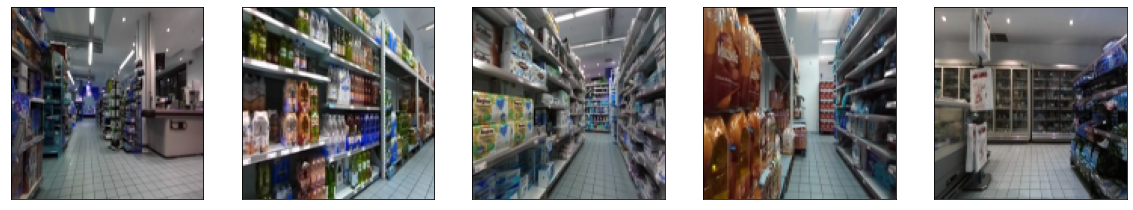

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #used because cv2.imshow get crushed in colab

N_IMAGES = 5    #number of images to be visualized

train = df_train.to_numpy()
files_train = train[:,0]
np.random.shuffle(files_train)

x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))


for i,file_name in enumerate(files_train[:N_IMAGES]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
print(files_train)

['2L010440.jpg' '1L010820.jpg' '1L020300.jpg' ... '1L036440.jpg'
 '4L017600.jpg' '050520.jpg']


# **Training the model**

In [37]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, BatchNormalization, Dropout, ReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model = Sequential([
            Conv2D(16, (3,3), activation = 'relu', padding='same',
                input_shape = (IMG_SIZE,IMG_SIZE,3)),
            MaxPooling2D((2, 2), padding='same'),#64x64x16
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x32
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#16x16x64
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x128
            Flatten(),
            Dense(128, activation='relu'),
            Dense(4)                                       
])

# model = Sequential([
#             Conv2D(16, (3,3), padding='same',
#                 input_shape = (IMG_SIZE,IMG_SIZE,3)),          
#             # Conv2D(16, (5, 5), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.4),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(32, (3, 2), padding='same'),
#             # Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.5),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(32, (3, 3), padding='same'),
#             # Conv2D(64, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.6),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(64, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.7),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(64, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.8),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(256, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.9),
#             MaxPooling2D((2, 2), padding='same'),

#             Flatten(),
#             Dense(4),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.9),
#             # Dense(512),
#             # Dense(4) #Linear activation to obtain full range [-inf, +inf] bc of regression
# ])

model.summary()

optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
model.compile(optimizer=optim, loss=loss)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 128)      

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
filepath = "/content/drive/My Drive/Colab_Notebooks/CV_Project/"
filepath_models = filepath + "saved_models/weights-improvement-{epoch:02d}-{val_loss:2f}.hdf5"
filepath_csv = filepath + "loss/my_logs.csv"

checkpoint = ModelCheckpoint(filepath_models, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", min_delta = 1, 
                           patience = 5, verbose = 1)
log_csv = CSVLogger(filepath_csv, separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

history = model.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
                    validation_steps = df_validation.shape[0]/BATCH_SIZE,
                    verbose=1,
                    validation_data = validation_dataset,
                    callbacks = callbacks_list,
                    workers = 8)



Epoch 1/50
21/20 [===============================] - ETA: 0s - loss: 40.1097
Epoch 00001: val_loss improved from inf to 38.81369, saving model to /content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/weights-improvement-01-38.813686.hdf5
21/20 [===============================] - 21s 1s/step - loss: 40.1097 - val_loss: 38.8137
Epoch 2/50
21/20 [===============================] - ETA: 0s - loss: 27.5209
Epoch 00002: val_loss improved from 38.81369 to 24.20501, saving model to /content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/weights-improvement-02-24.205009.hdf5
21/20 [===============================] - 19s 912ms/step - loss: 27.5209 - val_loss: 24.2050
Epoch 3/50
21/20 [===============================] - ETA: 0s - loss: 20.7848
Epoch 00003: val_loss improved from 24.20501 to 23.21533, saving model to /content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/weights-improvement-03-23.215334.hdf5
21/20 [===============================] - 19s 899ms/step - loss

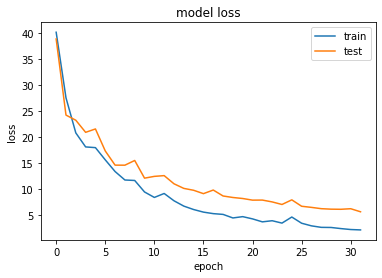

In [40]:
training_log = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/my_logs.csv").to_numpy()


loss = training_log[:,1]
val_loss = training_log[:,2]

#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/" + 'loss.png')
plt.show()

In [35]:
print(training_log)

[[ 0.         40.72733688 35.27630997]
 [ 1.         31.58856583 30.96261978]
 [ 2.         25.7499752  27.48642159]
 [ 3.         23.81227112 29.29701042]
 [ 4.         21.78913879 24.83689499]
 [ 5.         21.30340004 23.67930222]
 [ 6.         20.34390259 25.38561058]
 [ 7.         18.50001144 20.57454681]
 [ 8.         17.05878258 20.05230904]
 [ 9.         16.75128937 18.61929703]
 [10.         14.54778767 17.55108643]
 [11.         13.53404808 17.34414673]
 [12.         12.90587807 15.52159119]
 [13.         11.7643795  15.1953001 ]
 [14.         10.76235771 15.42141438]
 [15.         10.74196339 15.67721844]]
